# Streamlit stuff


### Pop up window

In [ ]:
@st.dialog("Add Position")
def add_position():
    if st.button("Option"):
        S = st.number_input("Spot")
        K = st.number_input("Strike")
        sigma = st.number_input("Sigma")
        T = st.number_input("DTE")
    
    elif st.button("Stock"):
        S = st.number_input("Spot")

In [ ]:
if st.button(f"Remove Position {i+1}"):
    st.session_state["positions"].remove(pos)
    continue

In [ ]:
from position_analysis.positions import Portfolio
import streamlit as st

def add_position():
    """Adds a new position to the session state."""
    pos_id = len(st.session_state["positions"]) + 1
    st.session_state["positions"].append(pos_id)
    st.session_state["selected_position"][pos_id] = None  # No type selected yet

def select_stock(pos_id):
    """Marks a position as a Stock."""
    st.session_state["selected_position"][pos_id] = "Stock"

def select_option(pos_id):
    """Marks a position as an Option."""
    st.session_state["selected_position"][pos_id] = "Option"

def main():

    if "positions" not in st.session_state:
        st.session_state["positions"] = []

    if "selected_position" not in st.session_state:
        st.session_state["selected_position"] = {}

    portfolio = Portfolio()
    st.button("Add Position", on_click=add_position)

    for i, pos_id in enumerate(st.session_state["positions"]):
        with st.container():
            st.write(f"### Position {pos_id}")

            # Stock & Option buttons in the same row
            col1, col2 = st.columns(2)
            with col1:
                st.button("Stock", key=f"stock_{pos_id}", on_click=select_stock, args=(pos_id,))
            with col2:
                st.button("Option", key=f"option_{pos_id}", on_click=select_option, args=(pos_id,))

            # Check which position type was selected and display corresponding inputs
            selected_type = st.session_state["selected_position"].get(pos_id)

            if selected_type == "Stock":
                col1, col2, col3 = st.columns(3)
                with col1:
                    ticker = st.text_input(f"Stock Ticker {pos_id}", key=f"ticker_{pos_id}")
                with col2:
                    stock_price = st.number_input(f"Stock Price {pos_id}", key=f"stock_price_{pos_id}")
                with col3:
                    quantity = st.number_input(f"Quantity {pos_id}", min_value=1, key=f"quantity_{pos_id}")
                
                # Store in portfolio (optional)
                portfolio.add_stock_position(stock_price, quantity)

            elif selected_type == "Option":
                col1, col2, col3, col4, col5, col6, col7, col8, col9 = st.columns(9)
                with col1:
                    ticker = st.text_input(f"Ticker {pos_id}", key=f"ticker_{pos_id}")
                with col2:
                    spot_price = st.number_input(f"Spot {pos_id}", key=f"spot_{pos_id}")
                with col3:
                    quantity = st.number_input(f"Quantity {pos_id}", min_value=1, key=f"quantity_{pos_id}")
                with col4:
                    K = st.number_input(f"Strike {pos_id}", key=f"strike_{pos_id}")
                with col5:
                    sigma = st.number_input(f"Sigma {pos_id}", key=f"sigma_{pos_id}")
                with col6:
                    T = st.number_input(f"DTE {pos_id}", key=f"dte_{pos_id}")
                with col7:
                    r = st.number_input(f"r {pos_id}", key=f"r_{pos_id}")
                with col8:
                    q = st.number_input(f"q {pos_id}", key=f"q_{pos_id}")
                with col9:
                    otype = st.selectbox(f"Type {pos_id}", ["Call", "Put"], key=f"otype_{pos_id}")

                # Store in portfolio (optional)
                portfolio.add_option_position(None, spot_price, K, T, sigma, r, otype, q, quantity)

    if len(portfolio.positions) == 0:
        pass

    else:
        for position in portfolio.positions:
            st.write(position)

if __name__ == "__main__":
    main()


In [3]:
import pyez_stats as ez
from data.price_data.process_price_data import get_log_rets

In [4]:
spy_rets = get_log_rets("SPY", "2020-01-01", "2021-01-01")
vix_rets = get_log_rets("^VIX", "2020-01-01", "2021-01-01")

------------------------
Regression Statistics
------------------------
Correlation        -0.735
R Square           0.540
Adjusted R Square  0.538
Standard Error     0.060
Observations       252
------------------------

ANOVA
---------------------------------------------------------------------
Source         df         SS         MS          F     Significance F
---------------------------------------------------------------------
Regression      1      1.058      1.058    293.775      0.00000000000
Residual      250      0.900      0.004
Total         251      1.958
---------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Source               Coefficients   Standard Error    t stat   P-value      Lower 95%      Upper 95%
----------------------------------------------------------------------------------------------------
Intercept                  0.0043           0.003

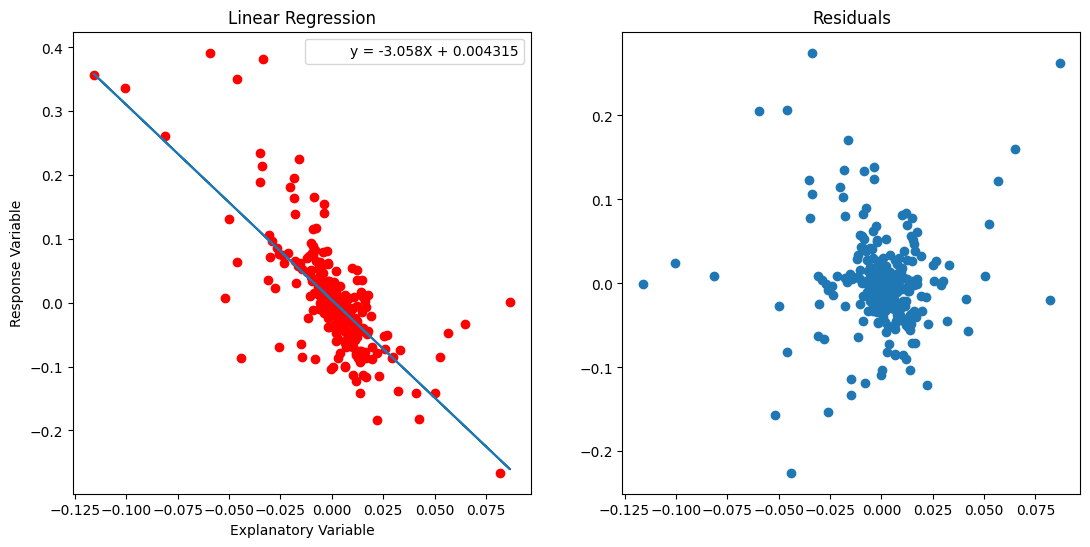

'Finished'

In [6]:
lin_reg = ez.LinearRegression(spy_rets, vix_rets)
lin_reg()

# Working with data processor

In [30]:
from data_processor.option_data_processor import OptionDataProcessor
import matplotlib.pyplot as plt

In [29]:
aapl_processor = OptionDataProcessor("AAPL", "2025-02-03")
aapl_processor.option_call_graph.get_expirations()

dict_keys(['2025-02-07', '2025-02-14', '2025-02-21', '2025-02-28', '2025-03-07', '2025-03-14', '2025-03-21', '2025-04-17', '2025-05-16', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2025-10-17', '2025-12-19', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-06-17'])

In [33]:
strikes, prices, ivs = zip(*aapl_processor.otm_put_call_data('2025-05-16'))

#plt.plot(strikes, ivs, 'o')
strikes

(100.0,
 105.0,
 115.0,
 130.0,
 135.0,
 140.0,
 145.0,
 150.0,
 155.0,
 160.0,
 165.0,
 170.0,
 175.0,
 180.0,
 185.0,
 190.0,
 195.0,
 200.0,
 205.0,
 210.0,
 215.0,
 220.0,
 225.0,
 230.0,
 235.0,
 240.0,
 245.0,
 250.0,
 255.0,
 260.0,
 265.0,
 270.0,
 275.0,
 280.0,
 290.0,
 295.0,
 300.0,
 320.0)

# Working with leetcode

In [19]:
class TreeNode:
    def __init__(self, val=0, left=None, right=None):
        self.val = val
        self.left = left
        self.right = right

class Node:
    def __init__(self, data = None, next = None):
        self.data = data
        self.next = next

In [104]:
from collections import deque
import heapq

arr = [5, 3, 6, 3, 22, 8, 9, 78]
arr_sort = sorted(arr)

graph = [[1, 2, 0],
         [0, 1, 2],
         [1, 1, 2]]

root = TreeNode(3)
root.left = TreeNode(9)
root.right = TreeNode(20, TreeNode(15, TreeNode(111, TreeNode(5))), TreeNode(7, TreeNode(10)))

In [21]:
class LinkedList:
    def __init__(self, data=None):
        self.head = Node(data) if data is not None else None

    def append(self, data):
        new_node = Node(data)
        if not self.head:  # Empty list
            self.head = new_node
            return
        curr = self.head
        while curr.next:
            curr = curr.next
        curr.next = new_node

    def print_list(self):
        curr = self.head
        while curr:
            print(curr.data, end=" -> ")
            curr = curr.next
        print("None")

llist = LinkedList(0)

# Append 1 through 9
for i in range(1, 10):
    llist.append(i)

# Print the list
llist.print_list()

0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8 -> 9 -> None


In [ ]:
def level_order(root):
    if not root:
        return []
    queue = deque([root])
    level = [[root.val]]
    temp = deque()
    while queue:
        node = queue.popleft()
        if node.left: temp.append(node.left)
        if node.right: temp.append(node.right)
        if not queue:
            if temp:
                level.append([n.val for n in temp])
            queue = temp
            temp = deque()
    return level

def permute(nums):
    res = []
    def backtrack(path, used):
        if len(path) == len(nums):
            res.append(path[:])  # make a copy
            return
        for i in range(len(nums)):
            if used[i]:
                continue
            used[i] = True
            path.append(nums[i])
            backtrack(path, used)
            path.pop()
            used[i] = False  # backtrack
    used = [False] * len(nums)
    backtrack([], used)
    return res


[[3], [9, 20], [15, 7], [111, 10], [5]]